# Определение наиболее выгодного региона нефтедобычи

**Задача**:<br>
Выбрать регион, добыча нефти в котором способна принести максимальную прибыль, а вероятность убытка минимальная.<br>
Условия задачи:
- При разведке региона исследуют 500 точек, из которых выбирают 200 лучших для разработки.
- Объём указан в тысячах баррелей, цена одной единицы продукции составляет 450 тыс.руб.
- Бюджет на разработку скважин в регионе — 10 млрд рублей<br>

**Дано**:<br>
10 000 месторождений, их характеристики и разведанный объём запасов нефти. 

**План решения**:<br>
1) Построить модель машинного обучения, которая предскажет запас нефти в месторождении по его характеристикам.<br>
2) Выбрать 500 месторождения случайным образом, далее из них выбрать 200 с максимальными предсказанными запасами нефти.<br>
3) Посчитать прибыль от добычи нефти из этих 200 месторождений по фактическим запасам c выше названными условиями.<br>
4) Проанализировать возможную прибыль и риски техникой *Bootstrap.* Отклонить регионы, где риск получения убытка превышает 2,5%.<br>
5) Из оставшихся регионов выбрать один с наибольшей средней прибылью.

## Загрузка и подготовка данных

In [52]:
# Импортируем библиотеки и модули
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error

In [53]:
# Введём константы для числовых значений из условий задачи:
UNIT_INCOME = 450_000 # Доход с одной единицы 'product'
BUDGET = 10_000_000_000 # Расходы: бюджет на разработку
WELLS_500 = 500 # 500 случайно отобранных скважин
WELLS_200 = 200 # Количество скважин для расчёта прибыли

In [54]:
#Преобразуем данные в таблицы
df_0 = pd.read_csv('geo_data_0.csv')
df_1 = pd.read_csv('geo_data_1.csv')
df_2 = pd.read_csv('geo_data_2.csv')

### Анализ данных

In [55]:
#Выводим первые строки датасетов
reg_dic = {'Регион 0': df_0, 'Регион 1': df_1, 'Регион 2': df_2}
for i in reg_dic:
    print(i)
    display(reg_dic[i].head(10))
    print('-')

Регион 0


,id,f0,f1,f2,product
0,txEyH,0.705745,-0.497823,1.221170,105.280062
1,2acmU,1.334711,-0.340164,4.365080,73.037750
2,409Wp,1.022732,0.151990,1.419926,85.265647
3,iJLyR,-0.032172,0.139033,2.978566,168.620776
4,Xdl7t,1.988431,0.155413,4.751769,154.036647
5,wX4Hy,0.969570,0.489775,-0.735383,64.741541
6,tL6pL,0.645075,0.530656,1.780266,49.055285
7,BYPU6,-0.400648,0.808337,-5.624670,72.943292
8,j9Oui,0.643105,-0.551583,2.372141,113.356160
9,OLuZU,2.173381,0.563698,9.441852,127.910945


-
Регион 1


,id,f0,f1,f2,product
0,kBEdx,-15.001348,-8.276000,-0.005876,3.179103
1,62mP7,14.272088,-3.475083,0.999183,26.953261
2,vyE1P,6.263187,-5.948386,5.001160,134.766305
3,KcrkZ,-13.081196,-11.506057,4.999415,137.945408
4,AHL4O,12.702195,-8.147433,5.004363,134.766305
5,HHckp,-3.327590,-2.205276,3.003647,84.038886
6,h5Ujo,-11.142655,-10.133399,4.002382,110.992147
7,muH9x,4.234715,-0.001354,2.004588,53.906522
8,YiRkx,13.355129,-0.332068,4.998647,134.766305
9,jG6Gi,1.069227,-11.025667,4.997844,137.945408


-
Регион 2


,id,f0,f1,f2,product
0,fwXo0,-1.146987,0.963328,-0.828965,27.758673
1,WJtFt,0.262778,0.269839,-2.530187,56.069697
2,ovLUW,0.194587,0.289035,-5.586433,62.871910
3,q6cA6,2.236060,-0.553760,0.930038,114.572842
4,WPMUX,-0.515993,1.716266,5.899011,149.600746
5,LzZXx,-0.758092,0.710691,2.585887,90.222465
6,WBHRv,-0.574891,0.317727,1.773745,45.641478
7,XO8fn,-1.906649,-2.458350,-0.177097,72.480640
8,ybmQ5,1.776292,-0.279356,3.004156,106.616832
9,OilcN,-1.214452,-0.439314,5.922514,52.954532


-


In [56]:
#Выводим общую информацию
for i in reg_dic:
    print(i)
    print(reg_dic[i].info())
    print('-')

Регион 0
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   id       100000 non-null  object 
 1   f0       100000 non-null  float64
 2   f1       100000 non-null  float64
 3   f2       100000 non-null  float64
 4   product  100000 non-null  float64
dtypes: float64(4), object(1)
memory usage: 3.8+ MB
None
-
Регион 1
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   id       100000 non-null  object 
 1   f0       100000 non-null  float64
 2   f1       100000 non-null  float64
 3   f2       100000 non-null  float64
 4   product  100000 non-null  float64
dtypes: float64(4), object(1)
memory usage: 3.8+ MB
None
-
Регион 2
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (

In [129]:
#Выводим информацию о данных в столбце 'product'
for i in reg_dic:
    print(i)
    print(reg_dic[i]['product'].describe())
    print('-')

Регион 0
count    100000.000000
mean         92.500000
std          44.288691
min           0.000000
25%          56.497507
50%          91.849972
75%         128.564089
max         185.364347
Name: product, dtype: float64
-
Регион 1
count    100000.000000
mean         68.825000
std          45.944423
min           0.000000
25%          26.953261
50%          57.085625
75%         107.813044
max         137.945408
Name: product, dtype: float64
-
Регион 2
count    100000.000000
mean         95.000000
std          44.749921
min           0.000000
25%          59.450441
50%          94.925613
75%         130.595027
max         190.029838
Name: product, dtype: float64
-


In [58]:
#Проверка на явные дубликаты
for i in reg_dic:
    print(i)
    print(reg_dic[i].duplicated().sum())

Регион 0
0
Регион 1
0
Регион 2
0


**Вывод**: Типы данных указаны корректно, пропуски и дубликаты не обнаружены

Регион 0
[[<AxesSubplot:title={'center':'f0'}> <AxesSubplot:title={'center':'f1'}>]
 [<AxesSubplot:title={'center':'f2'}>
  <AxesSubplot:title={'center':'product'}>]]


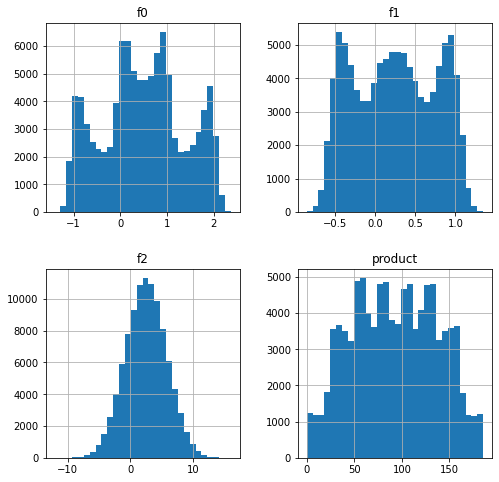

Регион 1
[[<AxesSubplot:title={'center':'f0'}> <AxesSubplot:title={'center':'f1'}>]
 [<AxesSubplot:title={'center':'f2'}>
  <AxesSubplot:title={'center':'product'}>]]


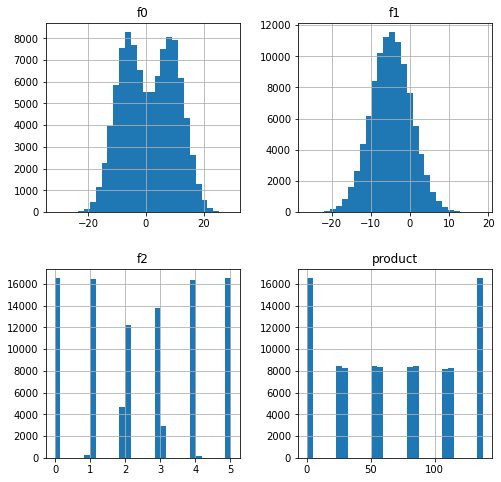

Регион 2
[[<AxesSubplot:title={'center':'f0'}> <AxesSubplot:title={'center':'f1'}>]
 [<AxesSubplot:title={'center':'f2'}>
  <AxesSubplot:title={'center':'product'}>]]


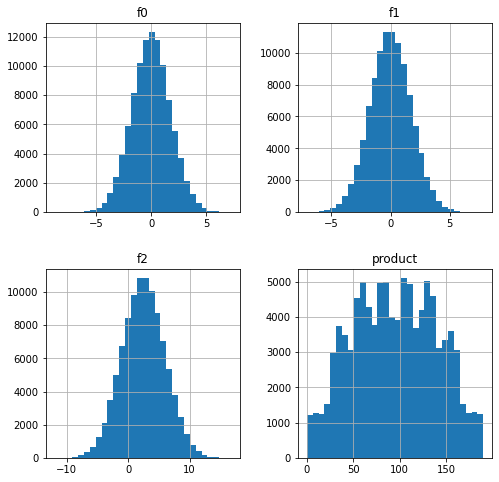

In [59]:
#Строим гистограммы столбцов
for i in reg_dic:
    print(i)
    print(reg_dic[i].hist(column=['f0', 'f1', 'f2', 'product'], bins=30, figsize=(8, 8)))
    plt.show()

In [60]:
#Изучим корреляцию product и остальных признаков
for i in reg_dic:
    print(i)
    for j in ['f0', 'f1', 'f2']:
        print('Корреляция product и', j, ':', reg_dic[i]['product'].corr(reg_dic[i][j]))

Регион 0
Корреляция product и f0 : 0.14353635093189251
Корреляция product и f1 : -0.19235576281513284
Корреляция product и f2 : 0.48366328692615274
Регион 1
Корреляция product и f0 : -0.030490530564375253
Корреляция product и f1 : -0.010154931786466117
Корреляция product и f2 : 0.999396970490655
Регион 2
Корреляция product и f0 : -0.001987061999049139
Корреляция product и f1 : -0.0010123938161308971
Корреляция product и f2 : 0.44587109155742083


Регион 0
AxesSubplot(0.125,0.125;0.62x0.755)


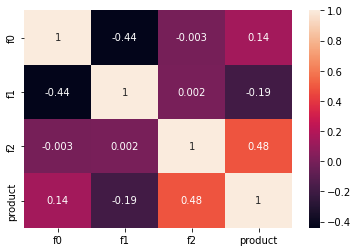

Регион 1
AxesSubplot(0.125,0.125;0.62x0.755)


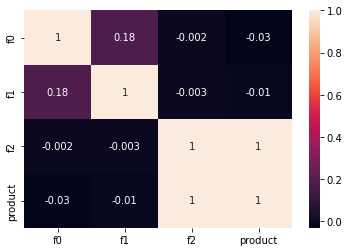

Регион 2
AxesSubplot(0.125,0.125;0.62x0.755)


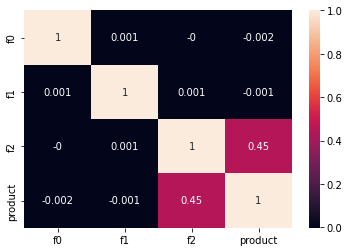

In [61]:
# Выведем тепловые карты корреляции
print('Регион 0')
print(sns.heatmap(df_0.corr().round(3), annot= True))
plt.show()
print('Регион 1')
print(sns.heatmap(df_1.corr().round(3), annot= True))
plt.show()
print('Регион 2')
print(sns.heatmap(df_2.corr().round(3), annot= True))

**Вывод**: В регионе 1 наблюдяется прямая корреляция целевого признака 'product' и признака 'f2'. Мультиколлениарность не обнаружена.

## Обучение и проверка модели

In [62]:
#Выделяем признаки и целевой признак
target_0 = df_0['product']
features_0 = df_0.drop(['id', 'product'], axis=1)
target_1 = df_1['product']
features_1 = df_1.drop(['id', 'product'], axis=1)
target_2 = df_2['product']
features_2 = df_2.drop(['id', 'product'], axis=1)

In [63]:
#Разделим датасеты на обучающую и валидационную выборки 
features_0_train, features_0_valid, target_0_train, target_0_valid = \
train_test_split(features_0, target_0, test_size=0.25, random_state=12345)
features_1_train, features_1_valid, target_1_train, target_1_valid = \
train_test_split(features_1, target_1, test_size=0.25, random_state=12345)
features_2_train, features_2_valid, target_2_train, target_2_valid = \
train_test_split(features_2, target_2, test_size=0.25, random_state=12345)

In [64]:
#Выводим размеры обчающих выборок
print(features_0_train.shape, target_0_train.shape)
print(features_1_train.shape, target_1_train.shape)
print(features_2_train.shape, target_2_train.shape)

(75000, 3) (75000,)
(75000, 3) (75000,)
(75000, 3) (75000,)


In [65]:
#Выводим размеры валидационных выборок
print(features_0_valid.shape, target_0_valid.shape)
print(features_1_valid.shape, target_1_valid.shape)
print(features_2_valid.shape, target_2_valid.shape)

(25000, 3) (25000,)
(25000, 3) (25000,)
(25000, 3) (25000,)


**Вывод**: разделение датасетов на выборки прошло корректно

In [66]:
#Объявляем переменные моделей и вносим их в список
model_0 = LinearRegression()
model_1 = LinearRegression()
model_2 = LinearRegression()
models = [model_0, model_1, model_2]

#Создаём списки признаков для обучения
targets = [target_0_train, target_1_train, target_2_train]
features = [features_0_train, features_1_train, features_2_train]

#Обучаем модели
for i in range (len(models)):
    models[i].fit(features[i], targets[i])

In [67]:
#Сjздадим списки с целевыми признаками и остальными признками
targets_valid = [target_0_valid, target_1_valid, target_2_valid]
features_valid = [features_0_valid, features_1_valid, features_2_valid]

#Получаем предсказания моделей
predicted_0_valid = model_0.predict(features_0_valid)
predicted_1_valid = model_1.predict(features_1_valid)
predicted_2_valid = model_2.predict(features_2_valid)

#Создади список с предсказаниями
predictions = [predicted_0_valid, predicted_1_valid, predicted_2_valid]

#Считаем средний заапс предск. сырья и RMSE
for i in range(len(targets_valid)):
    print('Регион', i)
    print("Средний запас предсказанного сырья в скважине:", predictions[i].mean())
    print("RMSE =", mean_squared_error(targets_valid[i], predictions[i]) ** 0.5)

Регион 0
Средний запас предсказанного сырья в скважине: 92.59256778438035
RMSE = 37.5794217150813
Регион 1
Средний запас предсказанного сырья в скважине: 68.728546895446
RMSE = 0.8930992867756165
Регион 2
Средний запас предсказанного сырья в скважине: 94.96504596800489
RMSE = 40.02970873393434


**Вывод**: Наибольший предсказанный средний запас сырья - в регионе 2, он составил 94.96 тыс. баррелей. В регионе 0 заапс сырья немного меньше - 92,59 тыс.баррелей. Запас сырья в регионе 1 намного ниже и составляет 68,72 тыс.баррелй.<br>
RMSE в регионах 0 и 2 не сильно отличаются, 37.57 и 40.02 соответственно. Выделяется регион 1, здесь RMSE = 0.893.

## Подготовка к расчёту прибыли

**Формула расчёта прибыли**<br><br>

Прибыль = Доход - Расходы<br>
Доход = (Доход с 1 ед. product) х (кол-во единиц product)<br>
Прибыль = (Доход с 1 ед. product) х (кол-во единиц product) - Расходы<br><br>

По условиям задачи:<br>
Доход с 1 ед. product = 450 000 р.<br>
Расходы = 10 000 000 000 р.

In [68]:
#Считаем мин. необходимый объём добычи сырья в тыс.баррелей (кол-во единиц product), чтобы окупить бюджет в 10 000 000 000 р.
print("Необходимый объём добытого сырья в регионе: ", BUDGET/UNIT_INCOME)
print("Необходимый объём добытого сырья для одной скважины: ", BUDGET/UNIT_INCOME/WELLS_200)

Необходимый объём добытого сырья в регионе:  22222.222222222223
Необходимый объём добытого сырья для одной скважины:  111.11111111111111


**Вывод**: Во всех регионах средний запас сырья в одной скважине меньше необходимого для безубыточности. Чтобы достичь безубыточности и получить прибыль, необходимо выбрать скважины с максимальным запасом сырья.

In [69]:
#Создадим функцию для подсчёта прибыли. Аргумент - объём сырья
def region_income(product_value):
    result = (product_value * UNIT_INCOME) - BUDGET
    
    return result

## Расчёт прибыли и рисков 

In [130]:
#Создадим объект RandomState для случайного отбора 500 скважин
state = np.random.RandomState(12345)

#Создадим список, в который будет добавляться результат работы функции:
# - Номер региона
# - Средняя прибыль
# - 2,5%-й квантиль - нижняя граница 95%-го доверительного интервала
# - 97,5%-й квантиль - верхняя граница 95%-го доверительного интервала
# - Риск убытка, или получения отрицательной прибыли
regions_list = []

#Создадим функцию с процедурой Bootstrap (1000 раз) для отбора 500 случ. скважин, и 200 из них с макс. предск. запасом сырья
#аргументы ф-ии: целевой признак на валид. выборке., предсказания на валид. в., номер региона
def bootstrap_1000(target_valid, predicted_valid, reg):
    means = [] #Список, в кот. будут добавляться средние значения прибыли от каждой итерации цикла
    for i in range(1000):
        #Передаём индексы target в predictions
        predicted_valid = pd.Series(predicted_valid, index=target_valid.index)
        #Отбираем случайные 500 скважин
        random_500 = predicted_valid.sample(n=WELLS_500, replace=True, random_state=state)
        #Из них выбираем индексы 200 с максимальным предсказанным объёмом сырья
        best_200 = random_500.sort_values(ascending=False).head(200).index
        #Отбираем из target по индексам 200 лучших скважин и считаем фактический объём сырья
        product_value = target_valid.loc[best_200].sum()
        #Рассчитываем прибыль для 200 скважин с макс. предсказанным объёмом сырья ф-ей region_income
        means.append(region_income(product_value)) #добавляем рез-т функции - расчёт прибыли - в список
        
    means = pd.Series(means)/1_000_000 #Переводим значения прибыли в млн. руб. 
    
    #Гистограмма распределения
    plt.figure(figsize=[8, 4])
    plt.xlim([-500, 1500])
    hist = plt.hist(means, bins=range(-500, 1500, 40), color='c', edgecolor='k', alpha=0.6)
    min_ylim, max_ylim  = plt.ylim()
    plt.title(label = 'Регион ' + str(reg) + '\n Распределение прибыли, \n 95%-й доверительный интервал', y=1.17)
    plt.xlabel('Прибыль, млн. руб.')
    plt.ylabel('Частота на 1000')
    plt.axvline(0, color='r', linestyle='dashed', linewidth=1.5)
    plt.axvline(means.quantile(0.025), color='k', linestyle='dashed', linewidth=1)
    plt.text(means.quantile(0.025), max_ylim*1.02, '2.5%-й квантиль \n: {:.2f}'.format(means.quantile(0.025)))
    plt.axvline(means.quantile(0.975), color='k', linestyle='dashed', linewidth=1)
    plt.text(means.quantile(0.975), max_ylim*1.02, '97.5% -й квантиль \n: {:.2f}'.format(means.quantile(0.975)))
    plt.show()

    #Заполняем список рассчитанными показателями
    regions_list.append([reg, means.mean(), means.quantile(0.025), means.quantile(0.975), (means<0).mean()*100])

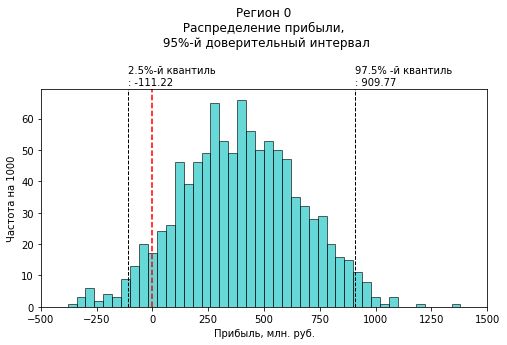

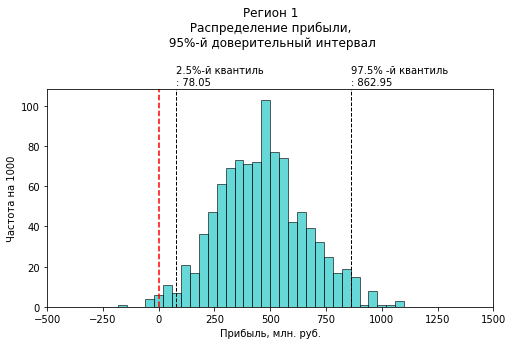

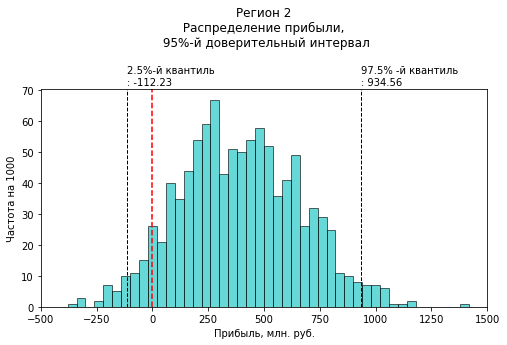

,№ региона,"Средняя прибыль, млн.руб","2.5%-й квантиль, млн.руб","97.5%-й квантиль, млн.руб","Вероятность убытка, %"
0,0,396.164985,-111.215546,909.766942,6.9
1,1,461.155817,78.050811,862.952060,0.7
2,2,392.950475,-112.227625,934.562915,6.5


In [131]:
#Считаем сред. прибыль, 95%-й дов. интервал, риск убытка и строим гистограмму распределения прибыли
regions_list = [] #обнуляем список с подсчитанными показателями региона

bootstrap_1000(target_0_valid, predicted_0_valid, 0)
bootstrap_1000(target_1_valid, predicted_1_valid, 1)
bootstrap_1000(target_2_valid, predicted_2_valid, 2)
#Создаём таблицу с подсчитанными показателями для всех регионов
income_data = pd.DataFrame(regions_list, columns=[
    '№ региона' , 'Средняя прибыль, млн.руб', '2.5%-й квантиль, млн.руб', '97.5%-й квантиль, млн.руб', 'Вероятность убытка, %'
])
income_data

**Вывод**: Условиям задачи удовлетворяет только регион №1, здесь вероятность убытка составила 0,7%. Плюс в этом регионе максимальная средняя прибыль.

## Общий вывод

По условиям задачи из трёх регионов: 0, 1 и 2 необходимо было выбрать один, в котором добыча нефти принесёт максимальную прибыль с миинмальным риском убытка. Количество скважин для разработки - 200 шт., бюджет на разработку для каждого региона - 10 000 000 руб. Для каждого из трёх регионов было предоставлено 100 000 точек с разведанными запасами сырья.<br><br>
В ходе исследования был рассчитан минимально необходимый для безубыточной и прибыльной добычи запас сырья в одной скважине, который составил 22 223 тыс. баррелей.<br>
Было получено среднее значение разведанного запаса сырья в одной скважине, которое оказалось меньше необхоимого для безубыточной и прибыльной добычи.<br><br>
Поэтому на основе данных по существующим скважинам была обучена модель, которая прогнозирует прибыль для новых скважин по их характеристикам.<br>
Для исключения влияния случайности на подсчёт прибыли техникой "Bootstrap" 1000 раз случайным образом отбиралось 500 скважин, из которых выбиралось 200 с максимальными предсказанными заапсами сырья. Далее для этих 200 скважин была рассчитана прибыль от фактических запасов.<br><br>
По результатам работы для добычи был выбран регион №1, средняя прибыль в котором оказалась максимальной в трёх регионах, а риск убытка составил 0,7%, против 6,9% и 6,5% в регионах 0 и 2 соответственно.